**Intent Detection - Enron**


In [38]:
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report

In [39]:
df_train=pd.read_csv("enron_train.txt",sep="\t",header=None)
df_test=pd.read_csv("enron_test.txt",sep="\t",header=None)

In [40]:
df_train.columns=["pred","content"]
df_test.columns=["pred","content"]

In [41]:
df_train['pred'].value_counts()

No     1938
Yes    1719
Name: pred, dtype: int64

In [42]:
df_test['pred'].value_counts()

No     683
Yes    309
Name: pred, dtype: int64

# Step 1 : Data Preprocessing - Expanding contractions & data cleaning

In [43]:
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [44]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,?#]')
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = text.lstrip()   
    text = text.rstrip()
    text = expandContractions(text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = re.sub(r"https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+"," ",text)
    text = re.sub(r"\$\d+", " ",text)
    text = re.sub(r'[\w\.-]+@[\w\.-]+', " ",text)
    text = re.sub(r'\b(me|her|him|us|them|there|that)\b', " ",text)  
    return text

In [45]:
'''REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,?#]')
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = text.lstrip()   
    text = text.rstrip()
    text = expandContractions(text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = re.sub(r"https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+","$WEBLINKS",text)
    text = re.sub(r"\$\d+", "$CASH",text)
    text = re.sub(r'[\w\.-]+@[\w\.-]+', "$EMAIL",text)
    text = re.sub(r'\b(me|her|him|us|them|there|that)\b', "$NOUN",text)  
    return text

'''

'REPLACE_BY_SPACE_RE = re.compile(\'[/(){}\\[\\]\\|@,?#]\')\ndef clean_text(text):\n    text = text.lower()\n    text = text.strip()\n    text = text.lstrip()   \n    text = text.rstrip()\n    text = expandContractions(text)\n    text = REPLACE_BY_SPACE_RE.sub(\' \', text)\n    text = re.sub(r"https?://(?:[-\\w.]|(?:%[\\da-fA-F]{2}))+","$WEBLINKS",text)\n    text = re.sub(r"\\$\\d+", "$CASH",text)\n    text = re.sub(r\'[\\w\\.-]+@[\\w\\.-]+\', "$EMAIL",text)\n    text = re.sub(r\'\x08(me|her|him|us|them|there|that)\x08\', "$NOUN",text)  \n    return text\n\n'

In [46]:
df_train['content'] = df_train['content'].astype(str).apply(clean_text)
df_test['content'] = df_test['content'].astype(str).apply(clean_text)

In [49]:
df_train.to_excel('train_analyze.xlsx')
df_test.to_excel('test_analyze.xlsx')

In [50]:
STOPWORDS = set(stopwords.words('english'))

In [51]:
lemmatizer = WordNetLemmatizer()

def tokenizer(text):
    return [lemmatizer.lemmatize(word) for word in word_tokenize(text) if len(word)>2 and (word not in STOPWORDS)]

# Create TF-IDF Vectors

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(min_df=0.01,tokenizer=tokenizer,stop_words=STOPWORDS)

X_train_tfidf = tfidf_vec.fit_transform(df_train['content'])

C:\Users\risha\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'ll", "'re", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [53]:
print(dict(zip(tfidf_vec.get_feature_names(), tfidf_vec.idf_)))

{"'ll": 5.07753744390572, '...': 5.127134385045092, 'able': 5.42048219503255, 'access': 5.541110182821164, 'account': 5.292648823522665, 'add': 5.144228818404391, 'address': 4.661377046680807, 'also': 4.693812322433961, 'app': 5.567085669224425, 'attached': 5.515792374836875, 'available': 4.65079493735027, 'back': 4.773855030107498, 'best': 5.541110182821164, 'book': 5.398009339180491, 'business': 5.292648823522665, 'call': 3.7240329056088197, 'chance': 5.491099762246503, 'change': 5.127134385045092, 'check': 4.970565324353552, 'click': 5.11032726672871, 'come': 5.0937979647775, 'company': 5.4670022106674425, 'conference': 5.354524227240752, 'contact': 4.941991951909495, 'copy': 5.292648823522665, 'could': 4.27019789582012, 'customer': 5.567085669224425, 'day': 4.531842994488905, 'deal': 5.045788745591139, 'dinner': 5.354524227240752, 'discus': 3.8386958139289598, 'discussion': 5.253428110369383, 'e-mail': 4.941991951909495, 'email': 3.8480855542787986, 'enron': 5.07753744390572, 'feel

In [54]:
X_test_tfidf  = tfidf_vec.transform(df_test['content'])

In [55]:
print("Train Shape : ",X_train_tfidf.shape)
print("Test Shape  : ",X_test_tfidf.shape)

Train Shape :  (3657, 125)
Test Shape  :  (992, 125)


In [56]:
train_pred=df_train["pred"]
test_pred=df_test["pred"]

# Splitting Original Training Set into 80% Train & 20% Validation

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
X_train,X_val,Y_train,Y_val=train_test_split(X_train_tfidf,train_pred,test_size=.20,random_state=40)

# Changing predictor values into numerics

In [59]:
Y_train=Y_train.map({"No":0,"Yes":1})
Y_val=Y_val.map({"No":0,"Yes":1})

# Checking Validation Accuracy with various classifiers

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier


In [61]:
svc = SVC(kernel='rbf', gamma="scale")
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
lrc = LogisticRegression(solver='liblinear', penalty='l2',C=10.)
rfc = RandomForestClassifier(n_estimators=100, random_state=111,n_jobs=-1,max_depth=7)
lgbm = LGBMClassifier(max_depth=10, n_estimators = 150)

In [62]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'LR': lrc, 'RF': rfc,'LGBM':lgbm}

In [63]:
def train(clf, features, targets):    
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [64]:
pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, Y_train)
    pred = predict(v, X_val)
    pred_scores_word_vectors.append((k, [accuracy_score(Y_val,pred)]))

In [65]:
predictions = pd.DataFrame.from_items(pred_scores_word_vectors,orient='index', columns=['Score'])
predictions

C:\Users\risha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """Entry point for launching an IPython kernel.


,Score
SVC,0.709016
KN,0.591530
NB,0.709016
LR,0.732240
RF,0.698087
LGBM,0.751366


In [66]:
import matplotlib.pyplot as plt
import numpy as np

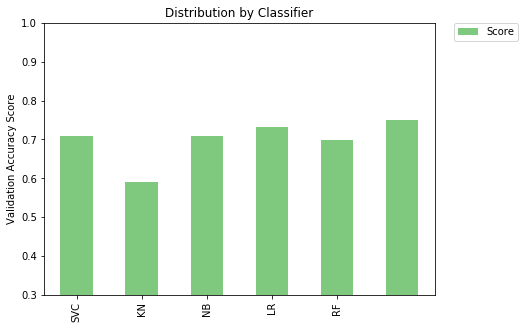

In [67]:
predictions.plot(kind='bar', ylim=(0.3,1.0), figsize=(7,5), align='center', colormap="Accent")
plt.xticks(np.arange(5), predictions.index)
plt.ylabel('Validation Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Let's test our models on the test set provided with our various classifiers

In [68]:
test_pred=test_pred.map({"No":0,"Yes":1})

In [69]:
tester = pd.DataFrame()

In [70]:
tester['LR_Model']=lrc.predict(X_test_tfidf)
tester['SVC_Model']=svc.predict(X_test_tfidf)
tester['RF_Model']=rfc.predict(X_test_tfidf)
tester['KNC_Model']=knc.predict(X_test_tfidf)
tester['NB_Model']=mnb.predict(X_test_tfidf)
tester['LGBM_Model']=lgbm.predict(X_test_tfidf)

# Logistic Regression Model

In [71]:
print('Testing accuracy: %s' % accuracy_score(tester['LR_Model'],test_pred))
print('Testing F1 score: {}'.format(f1_score(tester['LR_Model'],test_pred), average='weighted'))
print('Classification Report:')
print(classification_report(tester['LR_Model'],test_pred))

Testing accuracy: 0.7590725806451613
Testing F1 score: 0.6427503736920777
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       632
           1       0.70      0.60      0.64       360

   micro avg       0.76      0.76      0.76       992
   macro avg       0.74      0.72      0.73       992
weighted avg       0.75      0.76      0.75       992



# SVC Model

In [72]:
print('Testing accuracy: %s' % accuracy_score(tester['SVC_Model'],test_pred))
print('Testing F1 score: {}'.format(f1_score(tester['SVC_Model'],test_pred), average='weighted'))
print('Classification Report:')
print(classification_report(tester['SVC_Model'],test_pred))

Testing accuracy: 0.7782258064516129
Testing F1 score: 0.6180555555555556
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       725
           1       0.58      0.67      0.62       267

   micro avg       0.78      0.78      0.78       992
   macro avg       0.72      0.74      0.73       992
weighted avg       0.79      0.78      0.78       992



# Random Forest Model

In [73]:
print('Testing accuracy: %s' % accuracy_score(tester['RF_Model'],test_pred))
print('Testing F1 score: {}'.format(f1_score(tester['RF_Model'],test_pred), average='weighted'))
print('Classification Report:')
print(classification_report(tester['RF_Model'],test_pred))

Testing accuracy: 0.7862903225806451
Testing F1 score: 0.6074074074074075
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       761
           1       0.53      0.71      0.61       231

   micro avg       0.79      0.79      0.79       992
   macro avg       0.72      0.76      0.73       992
weighted avg       0.82      0.79      0.80       992



# Checking Feature Importances of RFC

In [74]:
print(list((zip(tfidf_vec.get_feature_names(), sorted(rfc.feature_importances_,reverse=True)))))

[("'ll", 0.23110609405782923), ('...', 0.11770564153562349), ('able', 0.08013727975668727), ('access', 0.05601729835865062), ('account', 0.054180826527012345), ('add', 0.0316459720203305), ('address', 0.02712835298286973), ('also', 0.019584672364621428), ('app', 0.016842879028746257), ('attached', 0.016768149606085515), ('available', 0.01656318516407336), ('back', 0.01653276669758887), ('best', 0.013110474069004518), ('book', 0.012940455569082193), ('business', 0.010203395630114322), ('call', 0.00923739875261138), ('chance', 0.008801696614507436), ('change', 0.008801426410322026), ('check', 0.008723978167848484), ('click', 0.008151793527230545), ('come', 0.00783020420880084), ('company', 0.0076390945453741164), ('conference', 0.007573082081973168), ('contact', 0.007480456486946817), ('copy', 0.006855749648202312), ('could', 0.006303250309876714), ('customer', 0.00616426992908247), ('day', 0.006097245733924505), ('deal', 0.005950008812866859), ('dinner', 0.0059423665150454864), ('discus

# K-Neighbours Classifier

In [75]:
print('Testing accuracy: %s' % accuracy_score(tester['KNC_Model'],test_pred))
print('Testing F1 score: {}'.format(f1_score(tester['KNC_Model'],test_pred), average='weighted'))
print('Classification Report:')
print(classification_report(tester['KNC_Model'],test_pred))

Testing accuracy: 0.7227822580645161
Testing F1 score: 0.3559718969555035
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.73      0.82       874
           1       0.25      0.64      0.36       118

   micro avg       0.72      0.72      0.72       992
   macro avg       0.59      0.69      0.59       992
weighted avg       0.86      0.72      0.77       992



# Multinomial Naive Bayes Model

In [76]:
print('Testing accuracy: %s' % accuracy_score(tester['NB_Model'],test_pred))
print('Testing F1 score: {}'.format(f1_score(tester['NB_Model'],test_pred), average='weighted'))
print('Classification Report:')
print(classification_report(tester['NB_Model'],test_pred))

Testing accuracy: 0.7338709677419355
Testing F1 score: 0.6140350877192982
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       617
           1       0.68      0.56      0.61       375

   micro avg       0.73      0.73      0.73       992
   macro avg       0.72      0.70      0.71       992
weighted avg       0.73      0.73      0.73       992



# LGBM Classifier

In [77]:
print('Testing accuracy: %s' % accuracy_score(tester['LGBM_Model'],test_pred))
print('Testing F1 score: {}'.format(f1_score(tester['LGBM_Model'],test_pred), average='weighted'))
print('Classification Report:')
print(classification_report(tester['LGBM_Model'],test_pred))

Testing accuracy: 0.75
Testing F1 score: 0.6242424242424242
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       641
           1       0.67      0.59      0.62       351

   micro avg       0.75      0.75      0.75       992
   macro avg       0.73      0.71      0.72       992
weighted avg       0.74      0.75      0.75       992

